# Greenhouse time-series model

Walk-forward model that uses external Bet Dagan weather and radiation data as exogenous features to predict internal greenhouse variables (air temp, RH, ET0, internal radiation). Each iteration trains on 1440 rows (10 days at 10 min), tests on 144 rows (1 day), then skips 144 rows (1 day) before the next training window.

In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
DATA_DIR = Path('.')
TRAIN_WINDOW = 1440  # 10 days of 10-minute samples
TEST_WINDOW = 144    # 1 day of 10-minute samples
GAP = 0            # no skip between train and test blocks
MAX_TRAIN_ROWS = None  # use full history (no cap)
from xgboost import XGBRegressor

In [18]:
# Load raw files
weather_path = DATA_DIR / "bet_dagan_weather.csv"
radiation_path = DATA_DIR / "bet_dagan_radiation.csv"
micro_path = DATA_DIR / "micro_climate_rh_t_et0.xlsx"

weather = pd.read_csv(weather_path)
radiation = pd.read_csv(radiation_path)
micro = pd.read_excel(micro_path).rename(columns={"internal_rh_%": "internal_rh_pct"})

# Replace Hebrew headers with ASCII names based on column order for reproducibility
weather.columns = [
    "station",
    "timestamp",
    "station_pressure_hpa",
    "rel_humidity_ext",
    "temp_c_ext",
    "temp_max_c_ext",
    "temp_min_c_ext",
    "temp_ground_c_ext",
    "temp_wet_c_ext",
    "wind_dir_deg",
    "gust_dir_deg",
    "wind_speed_ms",
    "wind_speed_max_1m_ms",
    "wind_speed_max_10m_ms",
    "wind_speed_max_10m_time",
    "gust_speed_ms",
    "wind_dir_std_deg",
]

radiation.columns = [
    "rad_station",
    "timestamp",
    "diffuse_rad_wm2",
    "global_rad_wm2",
    "direct_rad_wm2",
]

# Drop station id columns; we only need the measurements
weather = weather.drop(columns=["station"])
radiation = radiation.drop(columns=["rad_station"])

# Convert numeric columns
for df in (weather, radiation, micro):
    for col in df.columns:
        if col not in ("timestamp", "timestamp_dayfirst"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

# Robust parse for micro timestamps (handles mixed formats)
micro_ts_raw = micro["timestamp_dayfirst"].astype(str).str.replace("‏", "", regex=False).str.strip()
micro_ts = micro_ts_raw.apply(lambda x: pd.to_datetime(x, dayfirst=True, errors="coerce"))
unparsed = micro_ts.isna().sum()
if unparsed:
    print(f"Warning: {unparsed} micro rows had unparsable timestamps; dropping them")
micro = micro.assign(timestamp=micro_ts).dropna(subset=["timestamp"])

# Ensure micro is sorted and truncated to the expected campaign window
micro = micro.sort_values("timestamp").reset_index(drop=True)
expected_start = pd.Timestamp("2025-05-29 01:00:00")
micro = micro[micro["timestamp"] >= expected_start].reset_index(drop=True)

# Parse weather/radiation timestamps
weather["timestamp"] = pd.to_datetime(weather["timestamp"], dayfirst=True, format="mixed")
radiation["timestamp"] = pd.to_datetime(radiation["timestamp"], dayfirst=True, format="mixed")

weather = weather.drop(columns=[c for c in weather.columns if weather[c].isna().all()])
radiation = radiation.drop(columns=[c for c in radiation.columns if radiation[c].isna().all()])

# Moisture physics features
def calculate_saturation_vapor_pressure(temp_c):
    return 0.61078 * np.exp((17.27 * temp_c) / (temp_c + 237.3))

def calculate_vpd(temp_c, rh_pct):
    es = calculate_saturation_vapor_pressure(temp_c)
    ea = es * (rh_pct / 100.0)
    return es - ea

def calculate_absolute_humidity(temp_c, rh_pct):
    return (6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh_pct * 2.1674) / (273.15 + temp_c)

weather["vpd_ext"] = calculate_vpd(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["abs_humidity_ext"] = calculate_absolute_humidity(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["dew_point_ext"] = weather["temp_c_ext"] - ((100 - weather["rel_humidity_ext"]) / 5)

weather.head(), radiation.head(), micro.head()

(            timestamp  station_pressure_hpa  rel_humidity_ext  temp_c_ext  \
 0 2025-05-29 00:00:00                1009.0                70        21.5   
 1 2025-05-29 00:10:00                1008.9                70        21.5   
 2 2025-05-29 00:20:00                1008.8                70        21.5   
 3 2025-05-29 00:30:00                1008.8                71        21.4   
 4 2025-05-29 00:40:00                1008.8                71        21.3   
 
    temp_max_c_ext  temp_min_c_ext  temp_ground_c_ext  wind_dir_deg  \
 0            21.5            21.4               20.8           240   
 1            21.5            21.5               20.8           245   
 2            21.5            21.4               20.5           247   
 3            21.4            21.3               20.4           242   
 4            21.4            21.3               20.3           245   
 
    gust_dir_deg  wind_speed_ms  wind_speed_max_1m_ms  wind_speed_max_10m_ms  \
 0           238      

In [ ]:
# Align all sources on timestamp; keep micro as the spine to avoid dropping target rows when weather/radiation are missing
target_cols = ["internal_rh_pct"]
merged = micro.merge(weather, on="timestamp", how="left").merge(radiation, on="timestamp", how="left")
missing_rate = merged.isna().mean() * 100
display(missing_rate.sort_values(ascending=False))
# Reindex to a continuous 10-minute grid using the micro (target) span; fill only exogenous columns
full_range = pd.date_range(micro["timestamp"].min(), micro["timestamp"].max(), freq="10min")
reindexed = merged.set_index("timestamp").reindex(full_range)
reindexed.index.name = "timestamp"
reindexed = reindexed.reset_index()
exogenous_cols = [c for c in reindexed.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
reindexed = reindexed.set_index("timestamp")
reindexed[exogenous_cols] = reindexed[exogenous_cols].interpolate(method="time").bfill().ffill()
reindexed = reindexed.reset_index()
# Drop rows only if targets are missing
data = reindexed.dropna(subset=target_cols).sort_values("timestamp").reset_index(drop=True)
print(f"Rows after aligning, reindexing, and filling exogenous gaps: {len(data):,}")
print(f"Time span: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]}")

OUTLIER = [
    (pd.Timestamp("2025-09-11 00:00"), pd.Timestamp("2025-09-11 10:50")),
    (pd.Timestamp("2025-09-18 06:00"), pd.Timestamp("2025-09-18 09:00")),
    (pd.Timestamp("2025-08-27 08:00"), pd.Timestamp("2025-08-27 14:00")),
    (pd.Timestamp("2025-08-28 08:00"), pd.Timestamp("2025-08-28 11:00")),
]
if OUTLIER:
    before = len(data)
    for start, end in OUTLIER:
        data = data[(data["timestamp"] < start) | (data["timestamp"] > end)]
    removed = before - len(data)
    print(f"Removed {removed} rows based on OUTLIER")
    data = data.reset_index(drop=True)


# Calendar features
if 'timestamp' in data.columns:
    data['hour_of_day'] = data['timestamp'].dt.hour
    data['day_of_year'] = data['timestamp'].dt.dayofyear

# Rolling medians to smooth noisy externals (6-step = 60 minutes)
smooth_cols = [
    "global_rad_wm2",
    "diffuse_rad_wm2",
    "direct_rad_wm2",
    "temp_c_ext",
    "rel_humidity_ext",
]
for c in smooth_cols:
    if c in data.columns:
        data[f"{c}_med6"] = data[c].rolling(window=6, min_periods=1, center=True).median()

# External vapor pressure deficit (VPD) and dew point
if {"temp_c_ext", "rel_humidity_ext"}.issubset(data.columns):
    data["vpd_ext_calc"] = calculate_vpd(data["temp_c_ext"], data["rel_humidity_ext"])
    data["dew_point_ext_calc"] = data["temp_c_ext"] - ((100 - data["rel_humidity_ext"]) / 5)

# Engineered gradients/trends (trimmed to features used in importance plot)
if "dew_point_ext_calc" in data.columns and "temp_c_ext" in data.columns:
    data["dewpoint_gradient"] = data["dew_point_ext_calc"] - data["temp_c_ext"]

if "vpd_ext_calc" in data.columns:
    data["vpd_ext_rolling_mean_30min"] = data["vpd_ext_calc"].rolling(window=3, min_periods=1).mean()
    data["vpd_ext_min_1h"] = data["vpd_ext_calc"].rolling(window=6, min_periods=1).min()

if "global_rad_wm2" in data.columns:
    data["rad_integral_1h"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).sum()
    data["rad_peak_intensity"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).max()
    # Radiation ramp speed (positive at sunrise, negative at sunset)
    data["rad_slope_30m"] = data["global_rad_wm2"].diff(periods=3)  # 3*10min
    data["rad_slope_1h"] = data["global_rad_wm2"].diff(periods=6)   # 6*10min
    # Sunrise/Sunset heuristics from external radiation
    RAD_TRANSITION_THRESHOLD = 5  # W/m^2 threshold to mark day/night
    data["rad_is_low"] = data["global_rad_wm2"] <= RAD_TRANSITION_THRESHOLD
    data["sunrise_flag"] = (~data["rad_is_low"]) & (data["rad_is_low"].shift(1, fill_value=True))
    data["sunset_flag"] = data["rad_is_low"] & (~data["rad_is_low"].shift(1, fill_value=False))
    # Minutes since sunrise (only during daylight)
    sunrise_groups = data["sunrise_flag"].cumsum()
    data["minutes_since_sunrise"] = data.groupby(sunrise_groups).cumcount() * 10
    data.loc[data["rad_is_low"], "minutes_since_sunrise"] = np.nan
    # Minutes since sunset (only during darkness)
    sunset_groups = data["sunset_flag"].cumsum()
    data["minutes_since_sunset"] = data.groupby(sunset_groups).cumcount() * 10
    data.loc[~data["rad_is_low"], "minutes_since_sunset"] = np.nan

exclude_cols = ["internal_air_temp_c", "ET0", "internal_radiation"]
feature_cols = [c for c in data.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"] + exclude_cols]
data.head()

diffuse_rad_wm2          0.929145
ET0                      0.000000
internal_air_temp_c      0.000000
internal_rh_pct          0.000000
internal_radiation       0.000000
timestamp                0.000000
station_pressure_hpa     0.000000
rel_humidity_ext         0.000000
timestamp_dayfirst       0.000000
temp_c_ext               0.000000
temp_max_c_ext           0.000000
temp_ground_c_ext        0.000000
temp_min_c_ext           0.000000
gust_dir_deg             0.000000
wind_speed_ms            0.000000
wind_speed_max_1m_ms     0.000000
wind_dir_deg             0.000000
wind_speed_max_10m_ms    0.000000
gust_speed_ms            0.000000
vpd_ext                  0.000000
wind_dir_std_deg         0.000000
abs_humidity_ext         0.000000
dew_point_ext            0.000000
global_rad_wm2           0.000000
direct_rad_wm2           0.000000
dtype: float64

Rows after aligning, reindexing, and filling exogenous gaps: 16,682
Time span: 2025-05-29 01:00:00 -> 2025-09-21 23:00:00
Removed 105 rows based on OUTLIER


,timestamp,timestamp_dayfirst,ET0,internal_air_temp_c,internal_rh_pct,internal_radiation,station_pressure_hpa,rel_humidity_ext,temp_c_ext,temp_max_c_ext,...,dewpoint_gradient,vpd_ext_rolling_mean_30min,vpd_ext_min_1h,rad_integral_1h,rad_peak_intensity,rad_is_low,sunrise_flag,sunset_flag,minutes_since_sunrise,minutes_since_sunset
0,2025-05-29 01:00:00,29/05/2025 01:00:00,0.027900,22.775547,74.709380,0.0,1008.8,70.0,21.4,21.4,...,-6.0,0.764606,0.764606,0.0,0.0,True,False,True,NaN,0.0
1,2025-05-29 01:10:00,29/05/2025 01:10:00,0.022799,22.743830,74.193410,0.0,1008.7,70.0,21.3,21.3,...,-6.0,0.762271,0.759937,0.0,0.0,True,False,False,NaN,10.0
2,2025-05-29 01:20:00,29/05/2025 01:20:00,0.020941,22.473650,73.349106,0.0,1008.7,70.0,21.2,21.3,...,-6.0,0.759945,0.755292,0.0,0.0,True,False,False,NaN,20.0
3,2025-05-29 01:30:00,29/05/2025 01:30:00,0.020224,22.452467,71.715630,0.0,1008.7,68.0,21.1,21.2,...,-6.4,0.771982,0.755292,0.0,0.0,True,False,False,NaN,30.0
4,2025-05-29 01:40:00,29/05/2025 01:40:00,0.015574,22.511518,71.976640,0.0,1008.8,70.0,21.0,21.2,...,-6.0,0.767362,0.746077,0.0,0.0,True,False,False,NaN,40.0


In [20]:
# Define model and expanding walk-forward routine
base_estimator = XGBRegressor(
    n_estimators=1200,
    max_depth=8,
    learning_rate=0.03,
    min_child_weight=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    reg_alpha=0.1,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    tree_method='hist',
)

rh_feature_cols = None  # set after stage-1 predictions are available
rh_estimator = XGBRegressor(
    n_estimators=1200,
    max_depth=6,
    learning_rate=0.03,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.2,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    tree_method='hist',
)

def features_for_target(target):
    if target == "internal_rh_pct":
        if rh_feature_cols is None:
            raise ValueError("rh_feature_cols not set; define before RH walk_forward")
        return rh_feature_cols
    return feature_cols

def estimator_for_target(target):
    return rh_estimator if target == "internal_rh_pct" else base_estimator

def clip_predictions(target, preds):
    if target == "internal_rh_pct":
        return np.clip(preds, 0, 100)
    if target in ("ET0", "internal_radiation"):
        return np.clip(preds, 0, None)
    return preds

def walk_forward(df, feature_cols, target_cols, model, train_window=TRAIN_WINDOW, test_window=TEST_WINDOW, gap=GAP, max_train_rows=MAX_TRAIN_ROWS):
    """Expanding-window walk-forward: grow train set by each test block."""
    metrics = []
    preds = []
    train_end = train_window
    test_end = train_end + test_window
    run = 0

    while test_end <= len(df):
        train_start_idx = max(0, train_end - max_train_rows) if max_train_rows else 0
        train = df.iloc[train_start_idx:train_end]
        test = df.iloc[train_end:test_end]

        preds_run = {}
        metric = {
            "run": run,
            "train_start": train["timestamp"].iloc[0],
            "train_end": train["timestamp"].iloc[-1],
            "test_start": test["timestamp"].iloc[0],
            "test_end": test["timestamp"].iloc[-1],
            "train_rows": len(train),
            "test_rows": len(test),
        }

        for t_col in target_cols:
            feat_cols_t = features_for_target(t_col)
            model_t = estimator_for_target(t_col)
            model_t = clone(model_t)  # fresh instance
            model_t.fit(train[feat_cols_t], train[t_col])
            pred_t = model_t.predict(test[feat_cols_t])
            pred_t = clip_predictions(t_col, pred_t)
            preds_run[t_col] = pred_t
            metric[f"mae_{t_col}"] = mean_absolute_error(test[t_col], pred_t)
            mse = mean_squared_error(test[t_col], pred_t)
            metric[f"rmse_{t_col}"] = np.sqrt(mse)
            metric[f"r2_{t_col}"] = r2_score(test[t_col], pred_t)

        metrics.append(metric)
        preds.append(
            pd.concat(
                [
                    test[["timestamp"] + target_cols].reset_index(drop=True),
                    pd.DataFrame({f"pred_{t}": preds_run[t] for t in target_cols}),
                ],
                axis=1,
            ).assign(run=run)
        )

        print(
            f"Run {run}: train {metric['train_rows']} rows ({metric['train_start']} -> {metric['train_end']}), "
            f"test {metric['test_rows']} rows ({metric['test_start']} -> {metric['test_end']})"
        )
        for t_col in target_cols:
            print(
                f"  {t_col}: MAE={metric[f'mae_{t_col}']:.4f}, RMSE={metric[f'rmse_{t_col}']:.4f}, R2={metric[f'r2_{t_col}']:.4f}"
            )

        run += 1
        train_end += test_window  # expand training window by one test block (1 day)
        test_end = train_end + test_window

    if not metrics:
        raise ValueError("Not enough data for a single walk-forward run; check window sizes.")

    return pd.DataFrame(metrics), pd.concat(preds, ignore_index=True)

In [21]:
"""
Two-stage approach:
  1) Predict internal_air_temp_c, internal_radiation, ET0 using externals.
  2) Use externals + those predictions to predict internal_rh_pct.
"""

# Stage 1
stage1_targets = ["internal_air_temp_c", "internal_radiation", "ET0"]
stage1_pred_cols = [f"pred_{t}" for t in stage1_targets]
metrics_stage1, preds_stage1 = walk_forward(data, feature_cols, stage1_targets, base_estimator, max_train_rows=MAX_TRAIN_ROWS)
display(metrics_stage1)

# Latest predictions per timestamp
pred_latest = (
    preds_stage1.sort_values("timestamp")
    .drop_duplicates(subset=["timestamp"], keep="last")
    [["timestamp"] + stage1_pred_cols]
)
data_stage2 = data.merge(pred_latest, on="timestamp", how="left")

# Stage 2: RH using externals + stage1 predictions (no actual internals)
rh_features = [c for c in feature_cols if c not in stage1_targets + ["internal_rh_pct"]]
rh_feature_cols = rh_features + stage1_pred_cols
metrics_rh, preds_rh = walk_forward(data_stage2, rh_feature_cols, ["internal_rh_pct"], base_estimator, max_train_rows=MAX_TRAIN_ROWS)
display(metrics_rh)

def summarize_metrics(metrics_df, targets):
    rows = []
    for t in targets:
        row = {"variable": t}
        for metric in ("mae", "rmse", "r2"):
            col = f"{metric}_{t}"
            if col in metrics_df:
                row[metric] = metrics_df[col].mean()
        rows.append(row)
    return rows

summary_rows = []
summary_rows += summarize_metrics(metrics_stage1, stage1_targets)
summary_rows += summarize_metrics(metrics_rh, ["internal_rh_pct"])
summary = pd.DataFrame(summary_rows)
display(summary)

# Optional saves
metrics_stage1.to_csv("stage1_metrics.csv", index=False)
preds_stage1.to_csv("stage1_predictions.csv", index=False)
metrics_rh.to_csv("rh_metrics_stage2.csv", index=False)
preds_rh.to_csv("rh_predictions_stage2.csv", index=False)

Run 0: train 1440 rows (2025-05-29 01:00:00 -> 2025-06-08 00:50:00), test 144 rows (2025-06-08 01:00:00 -> 2025-06-09 00:50:00)
  internal_air_temp_c: MAE=0.5639, RMSE=0.6817, R2=0.9702
  internal_radiation: MAE=29.8486, RMSE=66.7672, R2=0.9276
  ET0: MAE=0.0331, RMSE=0.0525, R2=0.9341
Run 1: train 1584 rows (2025-05-29 01:00:00 -> 2025-06-09 00:50:00), test 144 rows (2025-06-09 01:00:00 -> 2025-06-10 00:50:00)
  internal_air_temp_c: MAE=0.3001, RMSE=0.3709, R2=0.9909
  internal_radiation: MAE=18.2026, RMSE=30.2584, R2=0.9834
  ET0: MAE=0.0269, RMSE=0.0383, R2=0.9655
Run 2: train 1728 rows (2025-05-29 01:00:00 -> 2025-06-10 00:50:00), test 144 rows (2025-06-10 01:00:00 -> 2025-06-11 00:50:00)
  internal_air_temp_c: MAE=0.3917, RMSE=0.4999, R2=0.9851
  internal_radiation: MAE=19.1920, RMSE=32.6539, R2=0.9816
  ET0: MAE=0.0262, RMSE=0.0353, R2=0.9716
Run 3: train 1872 rows (2025-05-29 01:00:00 -> 2025-06-11 00:50:00), test 144 rows (2025-06-11 01:00:00 -> 2025-06-12 00:50:00)
  internal_

,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_air_temp_c,rmse_internal_air_temp_c,r2_internal_air_temp_c,mae_internal_radiation,rmse_internal_radiation,r2_internal_radiation,mae_ET0,rmse_ET0,r2_ET0
0,0,2025-05-29 01:00:00,2025-06-08 00:50:00,2025-06-08 01:00:00,2025-06-09 00:50:00,1440,144,0.563904,0.681665,0.970166,29.848561,66.767222,0.927634,0.033111,0.052502,0.934104
1,1,2025-05-29 01:00:00,2025-06-09 00:50:00,2025-06-09 01:00:00,2025-06-10 00:50:00,1584,144,0.300097,0.370949,0.990894,18.202585,30.258421,0.983441,0.026866,0.038270,0.965507
2,2,2025-05-29 01:00:00,2025-06-10 00:50:00,2025-06-10 01:00:00,2025-06-11 00:50:00,1728,144,0.391735,0.499899,0.985139,19.192021,32.653922,0.981575,0.026176,0.035279,0.971587
3,3,2025-05-29 01:00:00,2025-06-11 00:50:00,2025-06-11 01:00:00,2025-06-12 00:50:00,1872,144,0.329097,0.399577,0.991503,24.806141,53.921483,0.953079,0.024206,0.033499,0.973776
4,4,2025-05-29 01:00:00,2025-06-12 00:50:00,2025-06-12 01:00:00,2025-06-13 00:50:00,2016,144,0.362680,0.512734,0.985618,33.104942,58.122336,0.942009,0.027207,0.038132,0.965573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,2025-05-29 01:00:00,2025-09-16 17:00:00,2025-09-16 17:10:00,2025-09-17 17:00:00,15840,144,0.676199,0.811060,0.947652,28.820400,55.855972,0.922478,0.025939,0.043969,0.922075
101,101,2025-05-29 01:00:00,2025-09-17 17:00:00,2025-09-17 17:10:00,2025-09-18 20:10:00,15984,144,0.583771,0.691708,0.974087,27.196342,57.207194,0.919196,0.027312,0.048103,0.914818
102,102,2025-05-29 01:00:00,2025-09-18 20:10:00,2025-09-18 20:20:00,2025-09-19 20:10:00,16128,144,0.738047,0.935358,0.915302,23.951921,46.553876,0.942946,0.025425,0.045679,0.913743
103,103,2025-05-29 01:00:00,2025-09-19 20:10:00,2025-09-19 20:20:00,2025-09-20 20:10:00,16272,144,0.382808,0.514861,0.980609,19.030745,33.624226,0.967861,0.019349,0.032339,0.951173


Run 0: train 1440 rows (2025-05-29 01:00:00 -> 2025-06-08 00:50:00), test 144 rows (2025-06-08 01:00:00 -> 2025-06-09 00:50:00)
  internal_rh_pct: MAE=5.0326, RMSE=6.5464, R2=0.5857
Run 1: train 1584 rows (2025-05-29 01:00:00 -> 2025-06-09 00:50:00), test 144 rows (2025-06-09 01:00:00 -> 2025-06-10 00:50:00)
  internal_rh_pct: MAE=2.5383, RMSE=3.2016, R2=0.8905
Run 2: train 1728 rows (2025-05-29 01:00:00 -> 2025-06-10 00:50:00), test 144 rows (2025-06-10 01:00:00 -> 2025-06-11 00:50:00)
  internal_rh_pct: MAE=3.4461, RMSE=4.5527, R2=0.8461
Run 3: train 1872 rows (2025-05-29 01:00:00 -> 2025-06-11 00:50:00), test 144 rows (2025-06-11 01:00:00 -> 2025-06-12 00:50:00)
  internal_rh_pct: MAE=2.5584, RMSE=3.2155, R2=0.8961
Run 4: train 2016 rows (2025-05-29 01:00:00 -> 2025-06-12 00:50:00), test 144 rows (2025-06-12 01:00:00 -> 2025-06-13 00:50:00)
  internal_rh_pct: MAE=2.3158, RMSE=2.8374, R2=0.9259
Run 5: train 2160 rows (2025-05-29 01:00:00 -> 2025-06-13 00:50:00), test 144 rows (2025-0

,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_rh_pct,rmse_internal_rh_pct,r2_internal_rh_pct
0,0,2025-05-29 01:00:00,2025-06-08 00:50:00,2025-06-08 01:00:00,2025-06-09 00:50:00,1440,144,5.032610,6.546401,0.585655
1,1,2025-05-29 01:00:00,2025-06-09 00:50:00,2025-06-09 01:00:00,2025-06-10 00:50:00,1584,144,2.538301,3.201648,0.890523
2,2,2025-05-29 01:00:00,2025-06-10 00:50:00,2025-06-10 01:00:00,2025-06-11 00:50:00,1728,144,3.446095,4.552716,0.846056
3,3,2025-05-29 01:00:00,2025-06-11 00:50:00,2025-06-11 01:00:00,2025-06-12 00:50:00,1872,144,2.558387,3.215477,0.896095
4,4,2025-05-29 01:00:00,2025-06-12 00:50:00,2025-06-12 01:00:00,2025-06-13 00:50:00,2016,144,2.315806,2.837448,0.925921
...,...,...,...,...,...,...,...,...,...,...
100,100,2025-05-29 01:00:00,2025-09-16 17:00:00,2025-09-16 17:10:00,2025-09-17 17:00:00,15840,144,4.520554,5.652853,0.786905
101,101,2025-05-29 01:00:00,2025-09-17 17:00:00,2025-09-17 17:10:00,2025-09-18 20:10:00,15984,144,7.225408,8.563537,0.249596
102,102,2025-05-29 01:00:00,2025-09-18 20:10:00,2025-09-18 20:20:00,2025-09-19 20:10:00,16128,144,4.800072,5.447374,0.644359
103,103,2025-05-29 01:00:00,2025-09-19 20:10:00,2025-09-19 20:20:00,2025-09-20 20:10:00,16272,144,5.052634,6.822825,0.498556


,variable,mae,rmse,r2
0,internal_air_temp_c,0.401807,0.524957,0.976747
1,internal_radiation,19.805785,38.155102,0.971046
2,ET0,0.022661,0.035599,0.964052
3,internal_rh_pct,2.566515,3.328759,0.865277


In [ ]:
# Grid search over radiation threshold for sunrise/sunset heuristics
thresholds = [3, 5, 10]
grid_rows = []
for thr in thresholds:
    df_thr = data.copy()
    rad = df_thr["global_rad_wm2"]
    df_thr["rad_is_low"] = rad <= thr
    df_thr["sunrise_flag"] = (~df_thr["rad_is_low"]) & (df_thr["rad_is_low"].shift(1, fill_value=True))
    df_thr["sunset_flag"] = df_thr["rad_is_low"] & (~df_thr["rad_is_low"].shift(1, fill_value=False))
    sunrise_groups = df_thr["sunrise_flag"].cumsum()
    df_thr["minutes_since_sunrise"] = df_thr.groupby(sunrise_groups).cumcount() * 10
    df_thr.loc[df_thr["rad_is_low"], "minutes_since_sunrise"] = np.nan
    sunset_groups = df_thr["sunset_flag"].cumsum()
    df_thr["minutes_since_sunset"] = df_thr.groupby(sunset_groups).cumcount() * 10
    df_thr.loc[~df_thr["rad_is_low"], "minutes_since_sunset"] = np.nan
    df_thr["rad_slope_30m"] = rad.diff(3)
    df_thr["rad_slope_1h"] = rad.diff(6)

    feature_cols_thr = [c for c in df_thr.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst", "internal_air_temp_c", "ET0", "internal_radiation"]]
    metrics_stage1_thr, preds_stage1_thr = walk_forward(df_thr, feature_cols_thr, stage1_targets, base_estimator, max_train_rows=MAX_TRAIN_ROWS)
    pred_latest_thr = (
        preds_stage1_thr.sort_values("timestamp")
        .drop_duplicates(subset=["timestamp"], keep="last")
        [["timestamp"] + [f"pred_{t}" for t in stage1_targets]]
    )
    data_stage2_thr = df_thr.merge(pred_latest_thr, on="timestamp", how="left")
    rh_features_thr = [c for c in feature_cols_thr if c not in stage1_targets + ["internal_rh_pct"]]
    rh_feature_cols_thr = rh_features_thr + [f"pred_{t}" for t in stage1_targets]
    metrics_rh_thr, _ = walk_forward(data_stage2_thr, rh_feature_cols_thr, ["internal_rh_pct"], base_estimator, max_train_rows=MAX_TRAIN_ROWS)
    grid_rows.append({"threshold": thr, "r2_rh": metrics_rh_thr["r2_internal_rh_pct"].mean(), "mae_rh": metrics_rh_thr["mae_internal_rh_pct"].mean()})

grid_results = pd.DataFrame(grid_rows)
display(grid_results)


C:\Users\User\AppData\Local\Temp\ipykernel_6728\2225760231.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


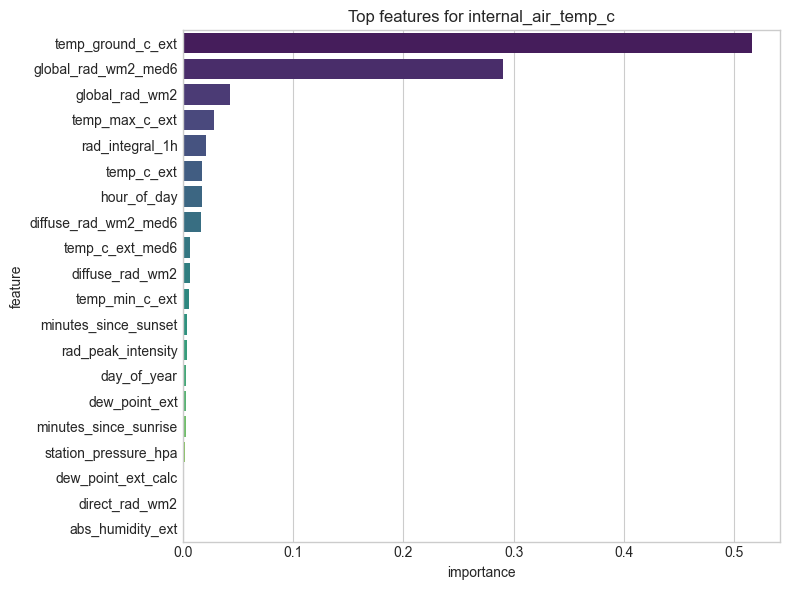

C:\Users\User\AppData\Local\Temp\ipykernel_6728\2225760231.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


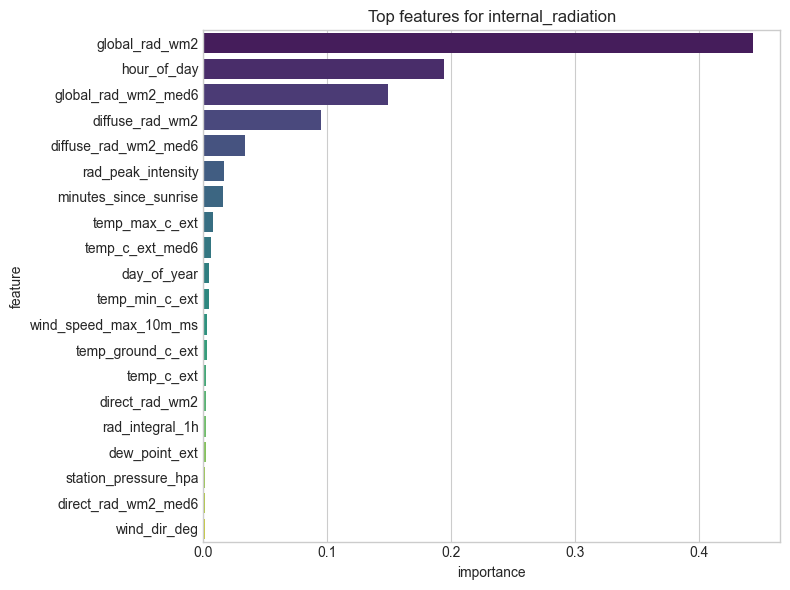

C:\Users\User\AppData\Local\Temp\ipykernel_6728\2225760231.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


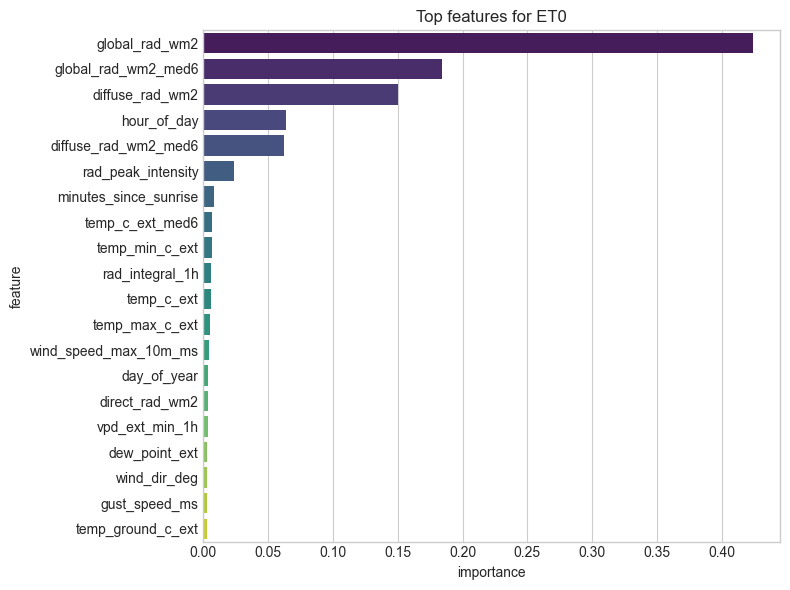

C:\Users\User\AppData\Local\Temp\ipykernel_6728\2225760231.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


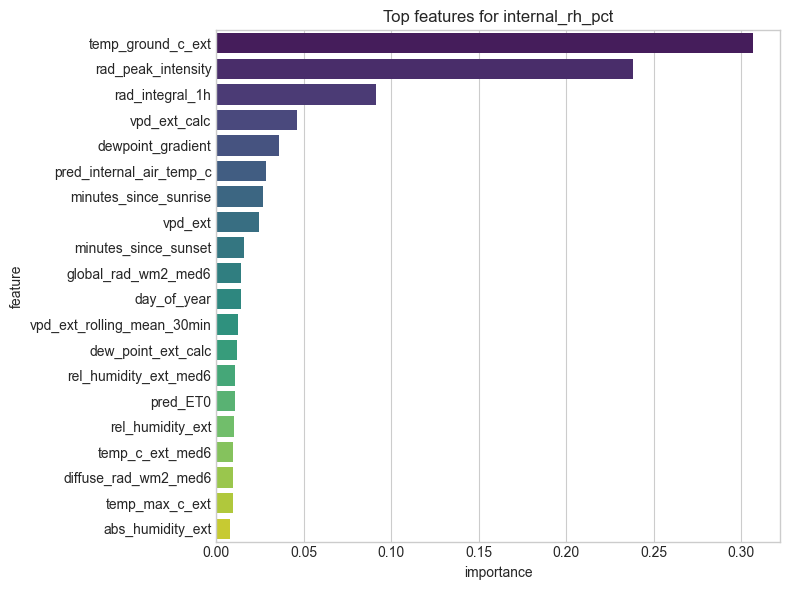

In [22]:
# Feature importance per target (trained once on full dataset)
# Stage 1 targets use externals (feature_cols); RH uses stage-1 predictions + externals (rh_feature_cols)
all_targets = stage1_targets + ["internal_rh_pct"]
importance_rows = []
for target in all_targets:
    if target in stage1_targets:
        feat_cols_t = feature_cols
        model_t = clone(base_estimator)
        X = data[feat_cols_t]
        y = data[target]
    else:  # internal_rh_pct
        feat_cols_t = rh_feature_cols
        model_t = clone(base_estimator)
        X = data_stage2[feat_cols_t]
        y = data_stage2[target]
    model_t.fit(X, y)
    fi = getattr(model_t, 'feature_importances_', None)
    if fi is None:
        print(f"No native feature_importances_ for target {target}; skipping")
        continue
    importance_rows.append(pd.DataFrame({"feature": feat_cols_t, "importance": fi, "target": target}))

if not importance_rows:
    print('No feature importances available for this model type/version.')
else:
    importance_df = pd.concat(importance_rows, ignore_index=True)
    for target in all_targets:
        sub = importance_df[importance_df['target'] == target].sort_values('importance', ascending=False).head(20)
        plt.figure(figsize=(8, 6))
        sns.barplot(x='importance', y='feature', data=sub, palette='viridis')
        plt.title(f'Top features for {target}')
        plt.tight_layout()
        plt.show()

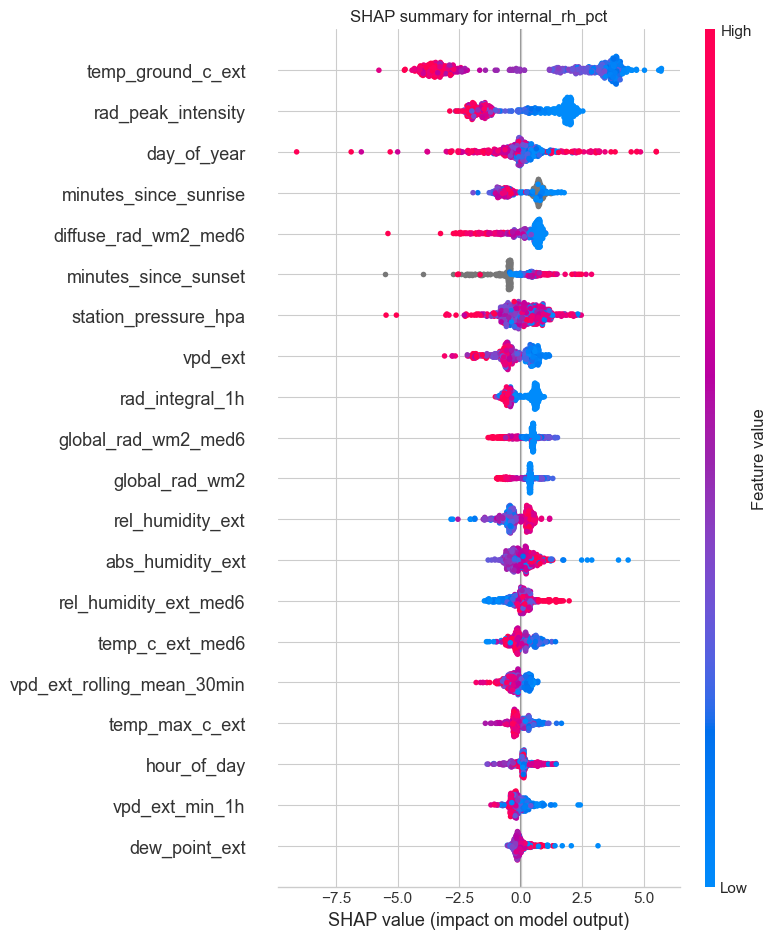

In [23]:
# SHAP explanation for RH on a sample (externals only)
import shap
shap.initjs()

rh_model = clone(rh_estimator)
rh_model.fit(data[feature_cols], data["internal_rh_pct"])

sample_n = min(500, len(data))
shap_sample = data.sample(sample_n, random_state=42)
explainer = shap.TreeExplainer(rh_model)
shap_values = explainer.shap_values(shap_sample[feature_cols])
shap.summary_plot(shap_values, shap_sample[feature_cols], show=False)
plt.title("SHAP summary for internal_rh_pct")
plt.tight_layout()
plt.show()

Found 13 low-R2 runs: [0, 63, 65, 70, 80, 81, 83, 84, 94, 95, 101, 102, 103]


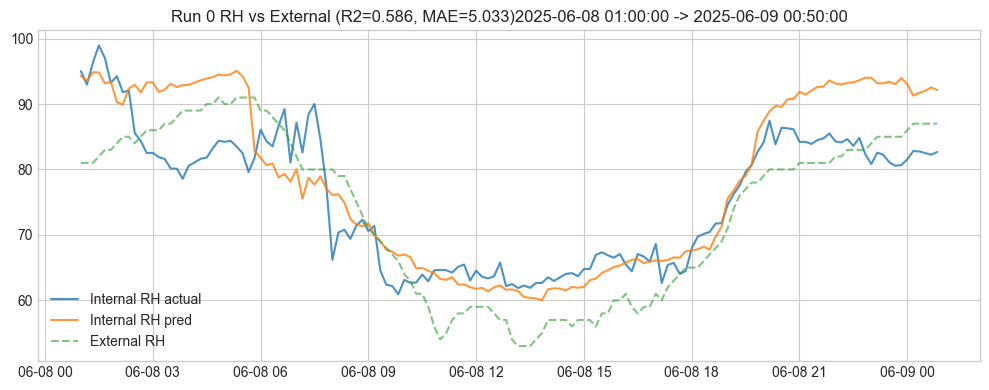

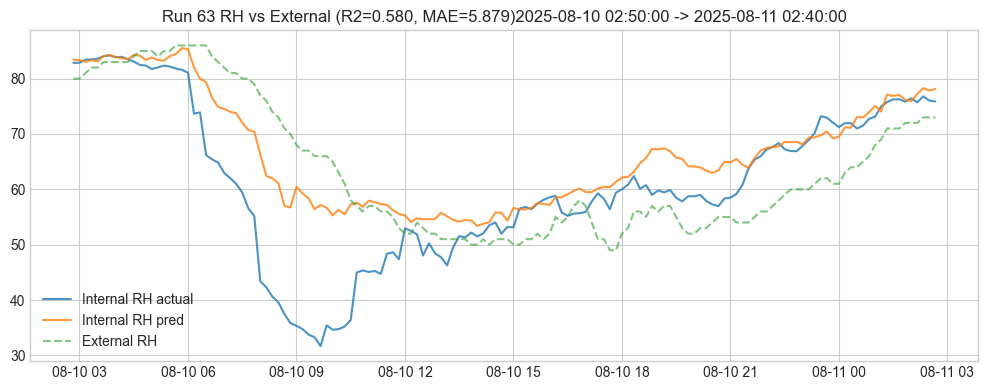

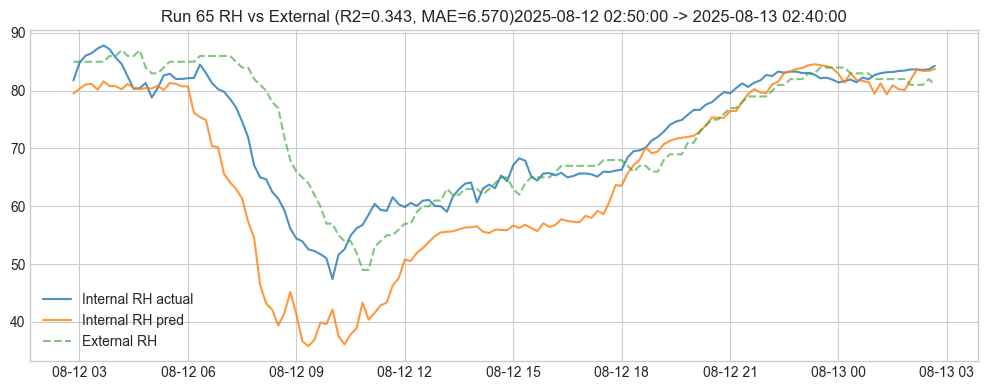

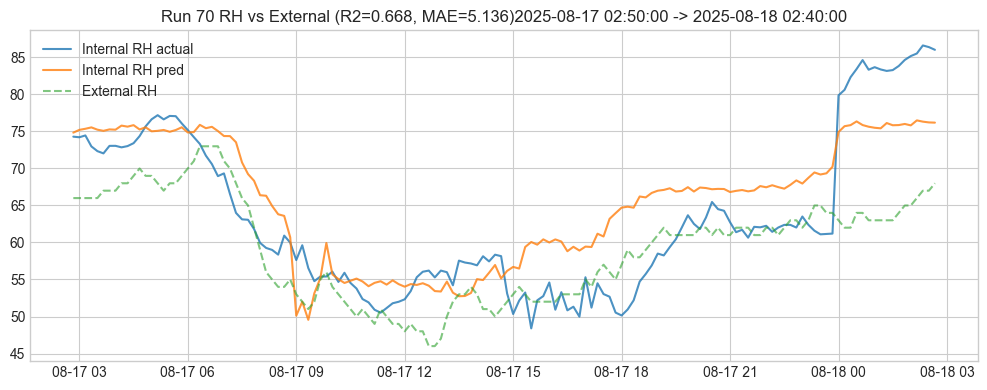

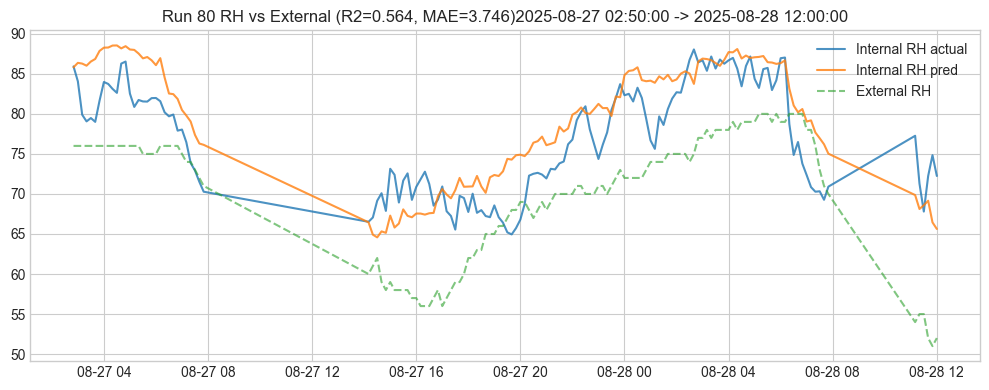

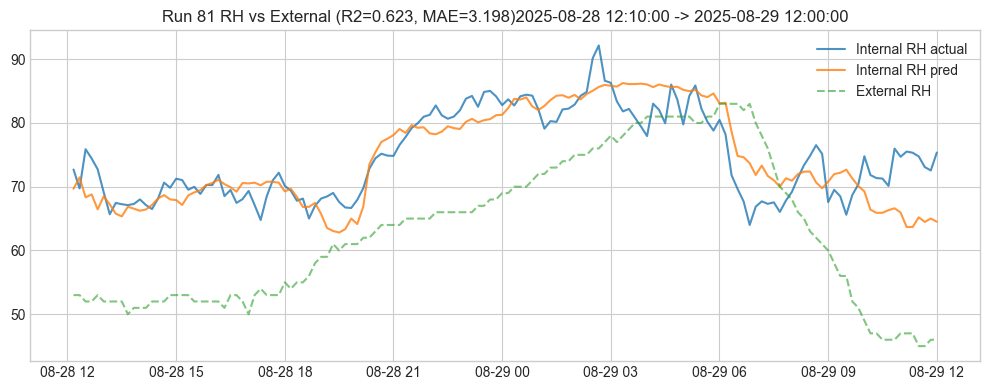

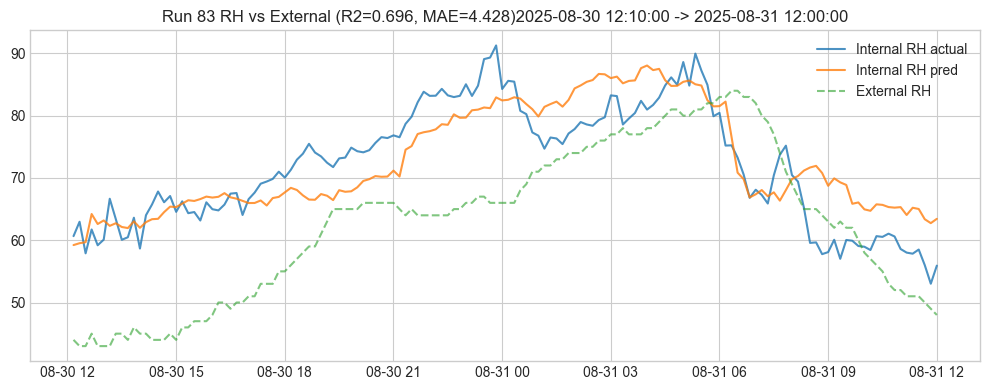

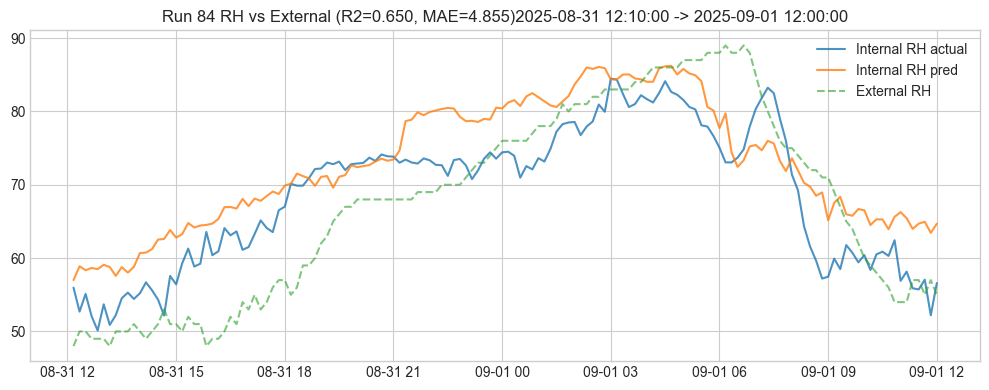

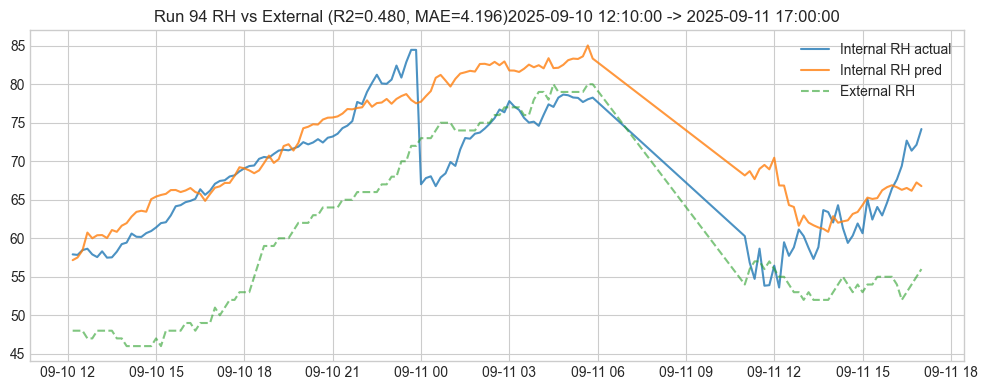

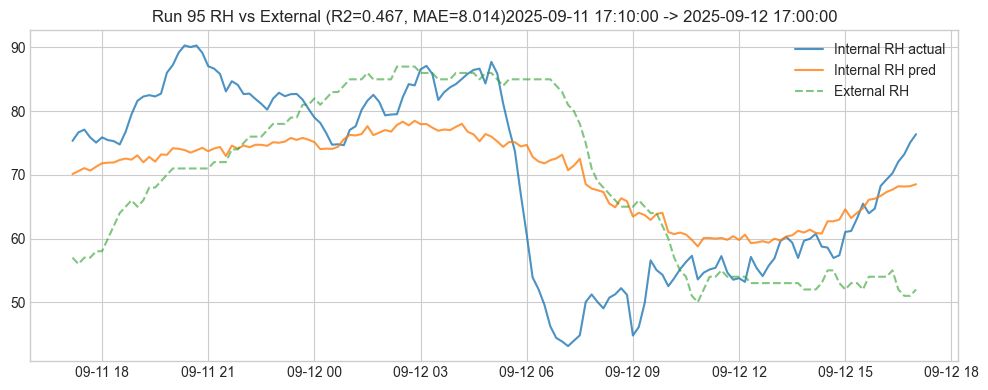

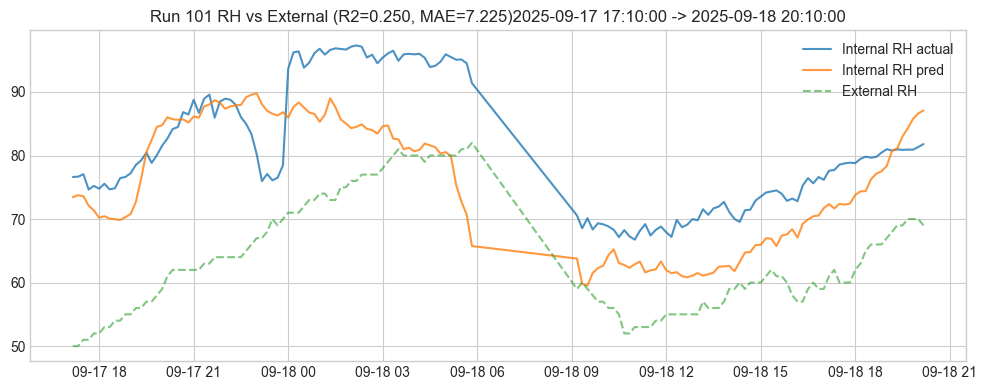

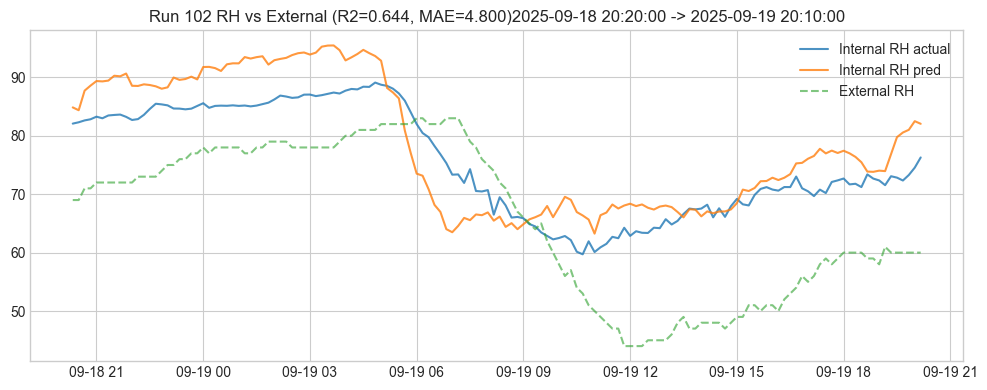

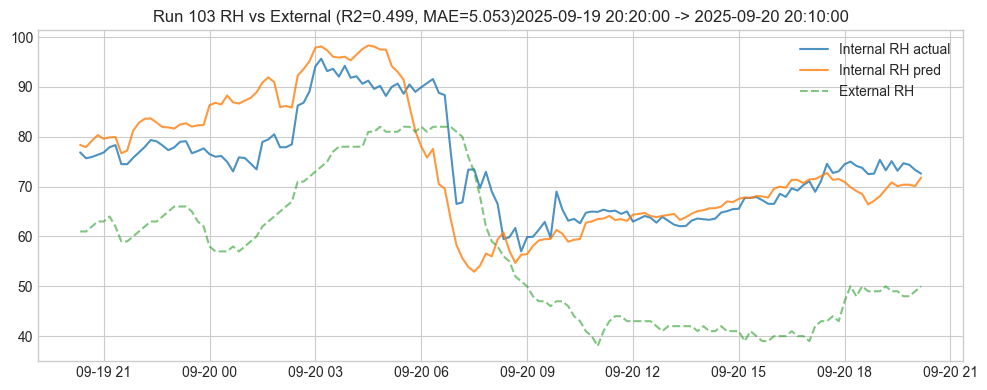

In [24]:
# Plot internal RH vs external RH for runs with low R2 (<0.7)
# metrics_df/preds_df come from stage-2 RH walk-forward
metrics_df = metrics_rh
preds_df = preds_rh
bad_runs = metrics_df[metrics_df.get('r2_internal_rh_pct', 1) < 0.7]
if bad_runs.empty:
    print('No runs with r2_internal_rh_pct < 0.7')
else:
    print(f"Found {len(bad_runs)} low-R2 runs: {bad_runs['run'].tolist()}")
    for _, row in bad_runs.iterrows():
        r = int(row['run'])
        test_start = row['test_start']
        test_end = row['test_end']
        # actual/pred from preds_df
        sub_pred = preds_df[preds_df['run'] == r]
        # external RH from original data in the test window
        ext_slice = data[(data['timestamp'] >= test_start) & (data['timestamp'] <= test_end)][['timestamp', 'rel_humidity_ext']]
        if sub_pred.empty or ext_slice.empty:
            print(f'Run {r}: missing data; skipping')
            continue
        merged = sub_pred.merge(ext_slice, on='timestamp', how='left')
        plt.figure(figsize=(10, 4))
        plt.plot(merged['timestamp'], merged['internal_rh_pct'], label='Internal RH actual', alpha=0.8)
        if 'pred_internal_rh_pct' in merged.columns:
            plt.plot(merged['timestamp'], merged['pred_internal_rh_pct'], label='Internal RH pred', alpha=0.8)
        plt.plot(merged['timestamp'], merged['rel_humidity_ext'], label='External RH', alpha=0.6, linestyle='--')
        if 'global_rad_wm2' in merged.columns:
            plt.plot(merged['timestamp'], merged['global_rad_wm2'], label='External Global Rad', alpha=0.5, linestyle=':')
        plt.title(f"Run {r} RH vs External (R2={row['r2_internal_rh_pct']:.3f}, MAE={row['mae_internal_rh_pct']:.3f}){test_start} -> {test_end}")
        plt.legend()
        plt.tight_layout()
        plt.show()
